In [374]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import scipy
from scipy.optimize import minimize
import numba
from scipy.interpolate import interp1d
# import seaborn as sns
# sns.set()

In [375]:
outdata = []
L_str = np.array(['0008', '0016', '0032', '0064', '0128'])
L_list = np.array([8,16,32,64,128])
T_list = np.arange(2.0, 2.51, 0.01)
for L in (L_str):
    file = open('output/mpi_L' + L + '_out.plt')
    csvreader = csv.reader(file)
    rows = []
    for row in csvreader:
        rows.append(row[:-1])
    outdata.append(rows)

outdata = np.float_(outdata)

# outdata[i][j][k]   
# i is the length 0 <-> L=8, 1 <-> L=16, 2 <-> L=32 and so on. (5) 
# j is the temperature of interest. goes from 0 to 51 for 2.0 to 2.50 (51)
# k is the observable of interest. 6 is energy, 10 is |magnetization|, 18 for chi, 20 for C_v, 22 for U_4. 

In [381]:
def return_obs_data(j):
    obs = np.array([((outdata[i].T)[j]) for i in range(len(L_list))])
    obs_error = np.array([((outdata[i].T)[j+1]) for i in range(len(L_list))])
    return obs, obs_error

tau, junk = return_obs_data(2)
edens, edens_error = return_obs_data(6) 
mag, mag_error = return_obs_data(16)
amag, amag_error = return_obs_data(10)
chi, chi_error = return_obs_data(18)
cv, cv_error = return_obs_data(20)
u_l, u_l_error = return_obs_data(22)

In [377]:
from itertools import combinations
def rSubset(arr, r):
    # return list of all subsets of length r
    # to deal with duplicate subsets use 
    # set(list(combinations(arr, r)))
    return list(combinations(arr, r))

In [378]:
def get_T_c(u_l):
    T_list = np.arange(2.0, 2.51, 0.01)
    difference_u_l = []
    combs = rSubset(np.arange(len(u_l)), 2)
    
    for comb in combs:
        difference_u_l.append(T_list[np.argmin(np.abs(u_l[comb[0]] - u_l[comb[1]])[20:30])+20])
        
    difference_u_l = np.array(difference_u_l)
    T_c = np.round(np.mean(difference_u_l),3)
    return(T_c)

T_c = get_T_c(u_l)
t_list = ((T_list-T_c)/T_c)
T_c

2.269

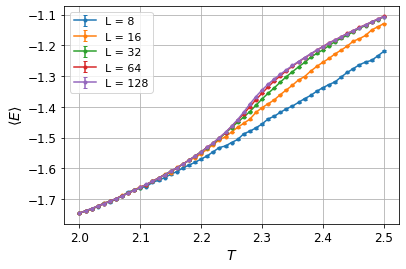

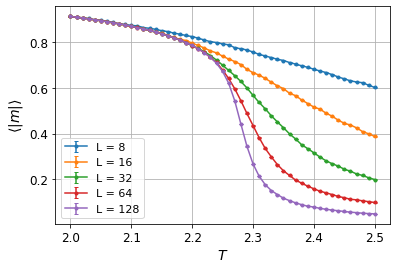

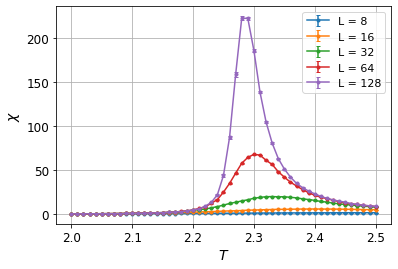

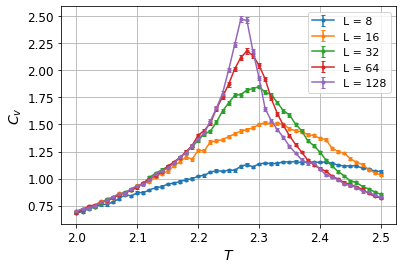

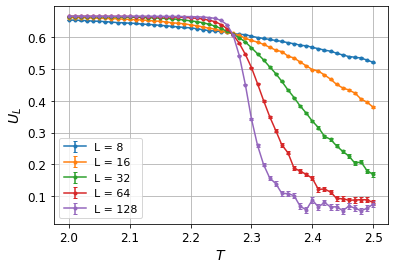

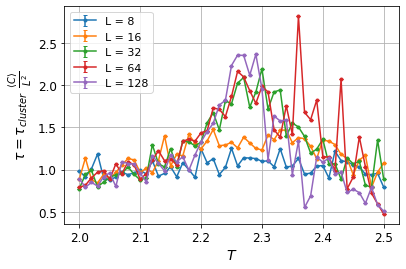

In [411]:
def plot_obs_vs_t(obs_string, obs, obs_error, name):
    plt.errorbar(T_list,obs[0], yerr = obs_error[0], fmt='.-', capsize=2)
    plt.errorbar(T_list,obs[1], yerr = obs_error[1], fmt='.-', capsize=2)
    plt.errorbar(T_list,obs[2], yerr = obs_error[2], fmt='.-', capsize=2)
    plt.errorbar(T_list,obs[3], yerr = obs_error[3], fmt='.-', capsize=2)
    plt.errorbar(T_list,obs[4], yerr = obs_error[4], fmt='.-', capsize=2)
    plt.xlabel(r'$T$', fontsize=14)
    plt.ylabel(obs_string, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['L = 8', 'L = 16','L = 32', 'L = 64', 'L = 128'], fontsize=11)
    plt.grid()
    plt.savefig("expvals vs T/" + name + ".pdf" , dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight",facecolor='white', transparent=False) 
    plt.show()


plot_obs_vs_t(r'$\langle E \rangle$', edens, edens_error, "edens")
# plot_obs_vs_t(r'$\langle m \rangle$', mag, mag_error, "magnetization")
plot_obs_vs_t(r'$\langle |m| \rangle$', amag, amag_error, "abs(mag)")
plot_obs_vs_t(r'$\chi$', chi, chi_error, "chi")
plot_obs_vs_t(r'$C_v$', cv, cv_error, "C_v")
plot_obs_vs_t(r'$U_L$', u_l, u_l_error, "U_L")
plot_obs_vs_t(r'$\tau = \tau_{cluster} \:\: \frac{\langle C \rangle}{L^2}$', tau, np.zeros(np.shape(edens_error)), "autocorr times")

# Data-collapse 

In [126]:
def Pb_function_relative_dev(zeta_or_nu, index_):
    Pb_list = []
    obs, obs_error = return_obs_data(index_)
    
    if(index_ == 22):
        zeta = 0
        nu = zeta_or_nu
    
    if(index_ == 10 or index_ == 18 or index_ == 20):
        zeta = zeta_or_nu
        nu = minimize(Pb_function_relative_dev, 0.3, args = (22)).x[0]

    for p in range(len(L_list)):
        E_p = interp1d(t_list*L_list[p]**(1/nu),obs[p]/(L_list[p]**(zeta/nu)), kind='cubic')
        x_low = np.amin(t_list*L_list[p]**(1/nu))
        x_high= np.amax(t_list*L_list[p]**(1/nu))
        
        for j in range(len(L_list)):
            if (j!=p):
                for i in range(len(t_list)):
                    x_val = (L_list[j]**(1/nu))*t_list[i]
                    if (x_low <= x_val and x_val <=x_high):
                        r2 = E_p(x_val)
                        r1 = (L_list[j]**(-zeta/nu))*obs[j][i]
                        Pb_list.append(abs(r1-r2)/((r1+r2)/2))
    Pb_list = np.array(Pb_list)
    Pb = np.mean(Pb_list)
    return Pb

In [386]:
nu_rel = minimize(Pb_function_relative_dev, 0.3, args=(22)).x[0]
print("ν estimated using relative deviation cost fn = ", nu_rel)

beta_rel = -minimize(Pb_function_relative_dev, 0.3, args=(10)).x[0]
print("β estimated using relative deviation cost fn = ", beta_rel)

gamma_rel = minimize(Pb_function_relative_dev, 0.3, args=(18)).x[0]
print("γ estimated using relative deviation cost fn = ", gamma_rel)

ν estimated using relative deviation cost fn =  0.9764651183345461
β estimated using relative deviation cost fn =  0.12038950817688962
γ estimated using relative deviation cost fn =  1.730094613069897


In [414]:
cost_nu = Pb_function_relative_dev(nu_rel, 22)
cost_beta = Pb_function_relative_dev(beta_rel, 10)
cost_gamma = Pb_function_relative_dev(gamma_rel, 18)

In [415]:
print(cost_nu, cost_beta, cost_gamma)

0.007922514171442935 0.3176668687693323 0.04335372739025578


In [409]:
def data_collapse(T_list, L_list, T_c, nu, index_, zeta):
    obs, obs_error = return_obs_data(index_)

    if (index_ == 10 or index_ == 18  or index_ == 22):
        for i in range(5):
            plt.plot(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)), obs[i]/(L_list[i]**(zeta/nu)), '.')
            
    elif(index_ == 20):
        for i in range(5):
            plt.plot(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)), obs[i]/(np.log(L_list[i])), '.')

    x_low = np.amin(((T_list-T_c)/T_c)*L_list[2]**(1/nu))
    x_high =  np.amax(((T_list-T_c)/T_c)*L_list[2]**(1/nu))
    
    plt.xlim([x_low, x_high])
#     plt.ylim([0, 1.7])
        
    if (index_ == 10):
        plt.ylabel(r'$\frac{\langle |m| \rangle}{L^{-\beta/\nu}}$', fontsize=18)
        name = "abs(mag) data collapse"
    elif(index_ == 18):
        plt.ylabel(r'$\frac{\chi}{L^{\gamma/\nu}}$', fontsize=18)
        name = "chi data collapse"
    elif(index_ == 20):
        plt.ylabel(r'$\frac{C_v}{\ln(L)}$', fontsize=18)
        name = "C_v data collapse"
    elif(index_ == 22):
        plt.ylabel(r'$U_L$', fontsize=14)
        name = "U_L data collapse"
        
    plt.xlabel(r'$t\: L^{1/\nu}$', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(['L = 8', 'L = 16','L = 32', 'L = 64', 'L = 128'],fontsize=11)
    plt.grid()
    plt.savefig("data collapse/" + name + ".pdf", dpi=(250), edgecolor='#f0f0f0', bbox_inches="tight",facecolor='white', transparent=False) 
    plt.show()

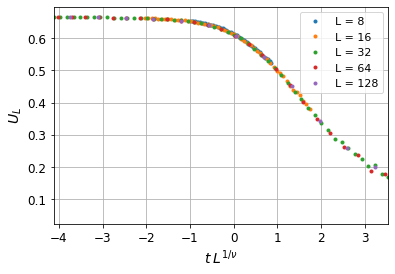

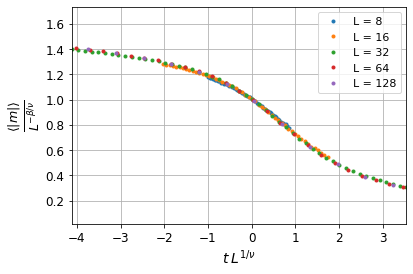

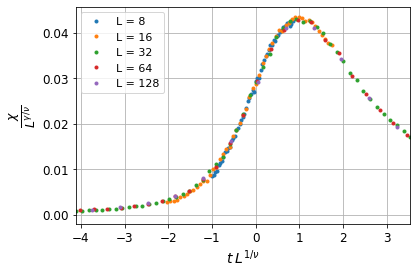

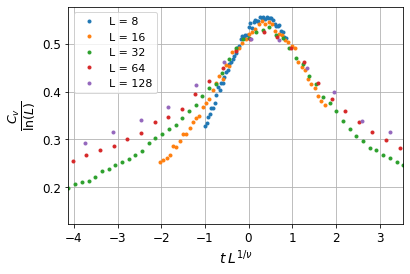

In [412]:
data_collapse(T_list, L_list, T_c, nu_rel, 22, zeta = 0)
data_collapse(T_list, L_list, T_c, nu_rel, 10, -beta_rel)
data_collapse(T_list, L_list, T_c, nu_rel, 18, gamma_rel)
data_collapse(T_list, L_list, T_c, nu_rel, 20, zeta = np.random.random())

# Quality of data collapse

In [162]:
def return_scaled_data(T_list, L_list, T_c, nu, index_, zeta):    
    x = []
    y = []
    dy = []
    obs, obs_error = return_obs_data(index_)

    if (index_ == 10 or index_ == 18  or index_ == 22):
        for i in range(len(L_list)):
            x.append(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)))
            y.append(obs[i]/(L_list[i]**(zeta/nu)))
            dy.append(obs_error[i]/(L_list[i]**(zeta/nu)))

    elif(index_ == 20):
        for i in range(len(L_list)):
            x.append(((T_list-T_c)/T_c)*(L_list[i]**(1/nu)))
            y.append(obs[i]/(np.log(L_list[i])))
            dy.append(obs_error[i]/(np.log(L_list[i])))
            
    return x, y, dy

In [302]:
def K_nm(x_l, y_l, w_l, n, m):
    sum_ = 0
    for l in range(len(x_l)):
        sum_ += w_l[l]*(x_l[l]**n)*(y_l[l]**m)
    
    return sum_

#---------------------------------------------------------------------------
def master_curve_ij(x, y, dy, i, j):
    samples = []
    
    for i_prime in range(np.shape(x)[0]):
        if (i_prime != i):
            for j_prime in range(np.shape(x)[1] - 1):
                if (x[i_prime][j_prime] <= x[i][j] and x[i][j] <= x[i_prime][j_prime + 1]):
                    samples.append([x[i_prime][j_prime], y[i_prime][j_prime], dy[i_prime][j_prime]])
                    samples.append([x[i_prime][j_prime + 1], y[i_prime][j_prime + 1], dy[i_prime][j_prime + 1]])
                    
    N_terms = len(samples)
    samples = np.array(samples).T
    
    if (N_terms!=0):
        w_l = 1/(samples[2]**2)
        x_l = samples[0]
        y_l = samples[1]

        K_00 = K_nm(x_l, y_l, w_l, 0, 0)
        K_10 = K_nm(x_l, y_l, w_l, 1, 0)
        K_11 = K_nm(x_l, y_l, w_l, 1, 1)
        K_20 = K_nm(x_l, y_l, w_l, 2, 0)
        K_01 = K_nm(x_l, y_l, w_l, 0, 1)
        K_02 = K_nm(x_l, y_l, w_l, 0, 2)

        delta = K_00*K_20 - K_10**2
        b = (K_20*K_01 - K_10*K_11)/delta
        m = (K_00*K_11 - K_10*K_01)/delta

        sigma_b2 = K_20/delta
        sigma_m2 = K_00/delta
        sigma_bm = -K_10/delta

        Y_ij = b + m*x[i][j]
        dY_ij2 = sigma_m2*(x[i][j]**2) + 2*sigma_bm*x[i][j] + sigma_b2
    
        return (Y_ij, dY_ij2, N_terms)
    
    else:
        return (0, 0, 0)
    
#-----------------------------------------------------------------------------
def quality_fn(x, y, dy):
    k = np.shape(x)[0]
    
    sum_ = 0
    for i in range(np.shape(x)[0]):
        N_i = 0
        for j in range(np.shape(x)[1]):
            Y_ij, dY_ij2, N_terms = master_curve_ij(x, y, dy, i, j)
            if(N_terms != 0):
                sum_ += ((y[i][j] - Y_ij)**2)/(dy[i][j]**2 + dY_ij2)
#                 sum_ += ((y[i][j] - Y_ij)**2)
                N_i += N_terms
        sum_ /= N_i
    
    S = sum_/k
    return(S)

In [345]:
x_1, y_1, dy_1 = return_scaled_data(T_list, L_list, T_c, nu_rel, 22, zeta = 0)
S_1 = quality_fn(x_1,y_1,dy_1)

x_2, y_2, dy_2 = return_scaled_data(T_list, L_list, T_c, nu_rel, 10, -beta_rel)
S_2 = quality_fn(x_2, y_2, dy_2)

x_3, y_3, dy_3 = return_scaled_data(T_list, L_list, T_c, nu_rel, 18, gamma_rel)
S_3 = quality_fn(x_3, y_3, dy_3)

x_4, y_4, dy_4 = return_scaled_data(T_list, L_list, T_c, nu_rel, 20, zeta = np.random.random())
S_4 = quality_fn(x_4, y_4, dy_4)

print("Quality of fit for scaled U_L data (ν) ", S_1)
print("Quality of fit for scaled |m| data (β) ", S_2)
print("Quality of fit for scaled chi data (γ) ", S_3)
print("Quality of fit for scaled C_v data ( ) ", S_4)

Quality of fit for scaled U_L data (ν)  1.6932919137626752
Quality of fit for scaled |m| data (β)  22.476412514999154
Quality of fit for scaled chi data (γ)  0.7371998119160674
Quality of fit for scaled C_v data ( )  6.935597963378837


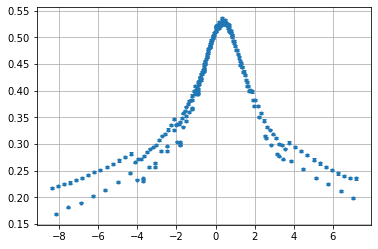

In [373]:
# x, y, dy = return_scaled_data(T_list, L_list, T_c, nu_rel, 22, zeta = 0)
# x, y, dy = return_scaled_data(T_list, L_list, T_c, nu_rel, 10, -beta_rel)
# x, y, dy = return_scaled_data(T_list, L_list, T_c, nu_rel, 18, gamma_rel)
x, y, dy = return_scaled_data(T_list, L_list, T_c, nu_rel, 20, zeta = np.random.random())


x_list = []
y_list = []
dy_list = []
for i in range(np.shape(x)[0]):
    for j in range(np.shape(x)[1]):
        Y_ij, dY_ij2, N_terms = master_curve_ij(x, y, dy, i, j)
        if (N_terms != 0):
            x_list.append(x[i][j])
            y_list.append(Y_ij)
            dy_list.append((dY_ij2)**(1/2))

plt.errorbar(x_list, y_list, yerr = dy_list, fmt='.', capsize=2)
plt.grid()
plt.show()

In [368]:
def reduced_chisq_stat(zeta_or_nu, index_):
    obs, obs_error = return_obs_data(index_)
    
    if(index_ == 22):
        zeta = 0
        nu = zeta_or_nu
    
    if(index_ == 10 or index_ == 18 or index_ == 20):
        zeta = zeta_or_nu
        nu = 1.035347605242605
        #nu = minimize(reduced_chisq_stat, 0.3, args = (22)).x[0]
        
    x, y, dy = return_scaled_data(T_list, L_list, T_c, nu, index_, zeta)
    S = quality_fn(x, y, dy)
    return (S)

nu_red = minimize(reduced_chisq_stat, 1, args=(22)).x[0]
print("ν estimated using relative deviation cost fn = ", nu_red)

beta_red = -minimize(reduced_chisq_stat, 0.5, args=(10)).x[0]
print("β estimated using relative deviation cost fn = ", beta_red)

gamma_red = minimize(reduced_chisq_stat, 0.5, args=(18)).x[0]
print("γ estimated using relative deviation cost fn = ", gamma_red)

ν estimated using relative deviation cost fn =  1.035358628122687
β estimated using relative deviation cost fn =  0.11163043431785401
γ estimated using relative deviation cost fn =  1.8015185853980091


In [413]:
x_1, y_1, dy_1 = return_scaled_data(T_list, L_list, T_c, nu_rel, 22, zeta = 0)
S_1 = quality_fn(x_1,y_1,dy_1)

x_2, y_2, dy_2 = return_scaled_data(T_list, L_list, T_c, nu_rel, 10, -beta_rel)
S_2 = quality_fn(x_2, y_2, dy_2)

x_3, y_3, dy_3 = return_scaled_data(T_list, L_list, T_c, nu_rel, 18, gamma_rel)
S_3 = quality_fn(x_3, y_3, dy_3)

x_4, y_4, dy_4 = return_scaled_data(T_list, L_list, T_c, nu_rel, 20, zeta = np.random.random())
S_4 = quality_fn(x_4, y_4, dy_4)

print("Quality of fit for scaled U_L data (ν) ", S_1)
print("Quality of fit for scaled |m| data (β) ", S_2)
print("Quality of fit for scaled chi data (γ) ", S_3)
print("Quality of fit for scaled C_v data ( ) ", S_4)

Quality of fit for scaled U_L data (ν)  1.6932919137626752
Quality of fit for scaled |m| data (β)  22.476412514999154
Quality of fit for scaled chi data (γ)  0.7371998119160674
Quality of fit for scaled C_v data ( )  6.935597963378837


In [418]:
Pb_list = []
obs, obs_error = return_obs_data(20)

nu = nu_rel

for p in range(len(L_list)):
    E_p = interp1d(t_list*L_list[p]**(1/nu),obs[p]/(np.log(L_list[p])), kind='cubic')
    x_low = np.amin(t_list*L_list[p]**(1/nu))
    x_high= np.amax(t_list*L_list[p]**(1/nu))

    for j in range(len(L_list)):
        if (j!=p):
            for i in range(len(t_list)):
                x_val = (L_list[j]**(1/nu))*t_list[i]
                if (x_low <= x_val and x_val <=x_high):
                    r2 = E_p(x_val)
                    r1 = obs[j][i]/np.log(L_list[j])
                    Pb_list.append(abs(r1-r2)/((r1+r2)/2))
Pb_list = np.array(Pb_list)
cost_log = np.mean(Pb_list)
cost_log

0.077802287228016

In [420]:
print(cost_nu)
print(cost_beta)
print(cost_gamma)
print(cost_log)

0.007922514171442935
0.3176668687693323
0.04335372739025578
0.077802287228016
